## Building a Multi-Linear Regression model

Building a multi-linear regression model involves several steps, including data preparation, model training, and evaluation.

## 1. Import Libraries

In [54]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## 2. Load Data

In [2]:
df = pd.read_csv('Bengaluru_House_Data1.csv')
df

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
...,...,...,...,...,...,...,...,...,...
13315,Built-up Area,Ready To Move,Whitefield,5 Bedroom,ArsiaEx,3453,4.0,0.0,231.00
13316,Super built-up Area,Ready To Move,Richards Town,4 BHK,NaN,3600,5.0,NaN,400.00
13317,Built-up Area,Ready To Move,Raja Rajeshwari Nagar,2 BHK,Mahla T,1141,2.0,1.0,60.00
13318,Super built-up Area,18-Jun,Padmanabhanagar,4 BHK,SollyCl,4689,4.0,1.0,488.00


In [3]:
df.shape

(13320, 9)

## * Data Cleaning

### Some features are not important to develop a model, so we can drop them.

In [4]:
df1 = df.drop(['area_type', 'availability', 'society'],axis='columns')
df1

,location,size,total_sqft,bath,balcony,price
0,Electronic City Phase II,2 BHK,1056,2.0,1.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,3.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,3.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,1.0,95.00
4,Kothanur,2 BHK,1200,2.0,1.0,51.00
...,...,...,...,...,...,...
13315,Whitefield,5 Bedroom,3453,4.0,0.0,231.00
13316,Richards Town,4 BHK,3600,5.0,NaN,400.00
13317,Raja Rajeshwari Nagar,2 BHK,1141,2.0,1.0,60.00
13318,Padmanabhanagar,4 BHK,4689,4.0,1.0,488.00


In [5]:
# Checking Missing  values in the dataset
df1.isnull().sum()

location        1
size           16
total_sqft      0
bath           73
balcony       609
price           0
dtype: int64

In [6]:
# Drop values with null values and write the remaining to df2
df2 = df1.dropna()
df2.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
balcony       0
price         0
dtype: int64

## Apply Feature Engineering
Add new feature for bedroom size

In [8]:
# N_bed is Number of bedrooms
df2['N_bed'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))
df2.N_bed.unique()

C:\Users\Specter\AppData\Local\Temp\ipykernel_20660\3859025089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['N_bed'] = df2['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  1,  6,  8,  7,  5, 11,  9, 27, 43, 14, 12, 10, 13],
      dtype=int64)

In the dataset, column total_sqft contains a ranges (e.g. 2100-2850). We can adjust this kind of data points by taking their average of min and max values of the range. As well as we remove data points the contains different measurement units to keep things simple.

In [9]:
# This function checks if a given input can be converted to a float or not. 
#It will return True if the conversion is successful and False otherwise. 
def is_float(x):
    try:
        float(x)
    except ValueError:
        return False
    return True

In [10]:
# Filters the Data points that contains rows where 'total_sqft' cannot be converted to a float.
df2[~df2['total_sqft'].apply(is_float)].head(5)

,location,size,total_sqft,bath,balcony,price,N_bed
30,Yelahanka,4 BHK,2100 - 2850,4.0,0.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,0.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,0.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,0.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,0.0,56.800,2


In [11]:
# Split the input string x by the '-' character 
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        # Convert both tokens to float and return their average
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        # If x is not a range, try to convert it directly to a float
        return float(x)
    except:
        return None

In [12]:
# Create a copy of the original DataFrame
df3 = df2.copy()

# Apply the convert_sqft_to_num function to the 'total_sqft' column
df3.total_sqft = df3.total_sqft.apply(convert_sqft_to_num)
df3 = df3[df3.total_sqft.notnull()]
# this show sample, an average of the range 2100-2850
#df3.loc[30]
df3.head(4)

,location,size,total_sqft,bath,balcony,price,N_bed
0,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3
3,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3


In [13]:
# Calculate the price per square foot and assign it to a new column 'price_per_sqft'
df4 = df3.copy()
df4['price_per_sqft'] = df4['price'] * 100000 / df4['total_sqft']
df4.head(5)

,location,size,total_sqft,bath,balcony,price,N_bed,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,1.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,3.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,3.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,1.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,1.0,51.00,2,4250.000000


In [14]:
df4['price_per_sqft'].describe()

count    1.266800e+04
mean     6.876277e+03
std      2.263354e+04
min      2.678298e+02
25%      4.242721e+03
50%      5.376344e+03
75%      7.142857e+03
max      2.300000e+06
Name: price_per_sqft, dtype: float64

## Examine categorical variable

In [15]:
# Strip leading and trailing whitespace from the 'location' column
df4.location = df4.location.apply(lambda x: x.strip())

# Calculate the frequency of each unique location
locations = df4['location'].value_counts(ascending=False)
locations

location
Whitefield           514
Sarjapur  Road       372
Electronic City      302
Kanakpura Road       259
Thanisandra          233
                    ... 
Subbannaiah Palya      1
whitefiled             1
Medi Agrahara          1
Sadduguntepalya        1
Abshot Layout          1
Name: count, Length: 1248, dtype: int64

In [16]:
locations.values.sum()
len(locations[locations>10])
len(locations[locations<=10])

1013

## Dimensionality Reduction

Locations having values less than 10 data points should be tagged as 'other' locations. This tagging helps to reduce huge number of locations and later we use one hot encoding.

In [17]:
locations_less_than_10 = locations[locations<=10]

df4.location = df4.location.apply(lambda x: 'other' if x in locations_less_than_10 else x)
len(df4.location.unique())

236

## Outlier Removal

Outliers can be detected and handled using different way. As a Data scientist we may have conversion with real estate experts, we can identify that normally square ft per bedroom. For example 1 bedroom apartment is minimum 300 sqft and 2 with 600 sqft.

In [18]:
df4[df4.total_sqft/df4.N_bed<300].head()

,location,size,total_sqft,bath,balcony,price,N_bed,price_per_sqft
58,Murugeshpalya,6 Bedroom,1407.0,4.0,1.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,0.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,2.0,100.0,3,20000.000000
78,Kaval Byrasandra,2 BHK,460.0,1.0,0.0,22.0,2,4782.608696
89,Rajaji Nagar,6 Bedroom,710.0,6.0,3.0,160.0,6,22535.211268


In [19]:
df5 = df4[~(df4.total_sqft/df4.N_bed<300)]
df5.shape

(12013, 8)

### Outlier Removal Using Standard Deviation and Mean

In [20]:
df5.price_per_sqft.describe()

count     12013.000000
mean       6206.082347
std        3985.518807
min         267.829813
25%        4199.363057
50%        5252.525253
75%        6823.529412
max      176470.588235
Name: price_per_sqft, dtype: float64

Min price per sqft is 267.8 rs/sqft whereas max is 176470.58, this shows a wide variation in real estate prices. We should remove outliers per location using mean and one standard deviation

In [21]:
#This function groups the DataFrame by 'location', calculates the mean and standard deviation of price_per_sqft, 
#and filters out the outliers

def remove_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df6 = remove_outliers(df5)
df6.shape

(9852, 8)

In [22]:
#This function groups the DataFrame by 'location', calculates the mean and standard deviation of bedroom, 
#and filters out the outliers
def remove_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('N_bed'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('N_bed'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df7 = remove_outliers(df6)
# df7 = df6.copy()
df7.shape

(7014, 8)

Text(0, 0.5, 'Count')

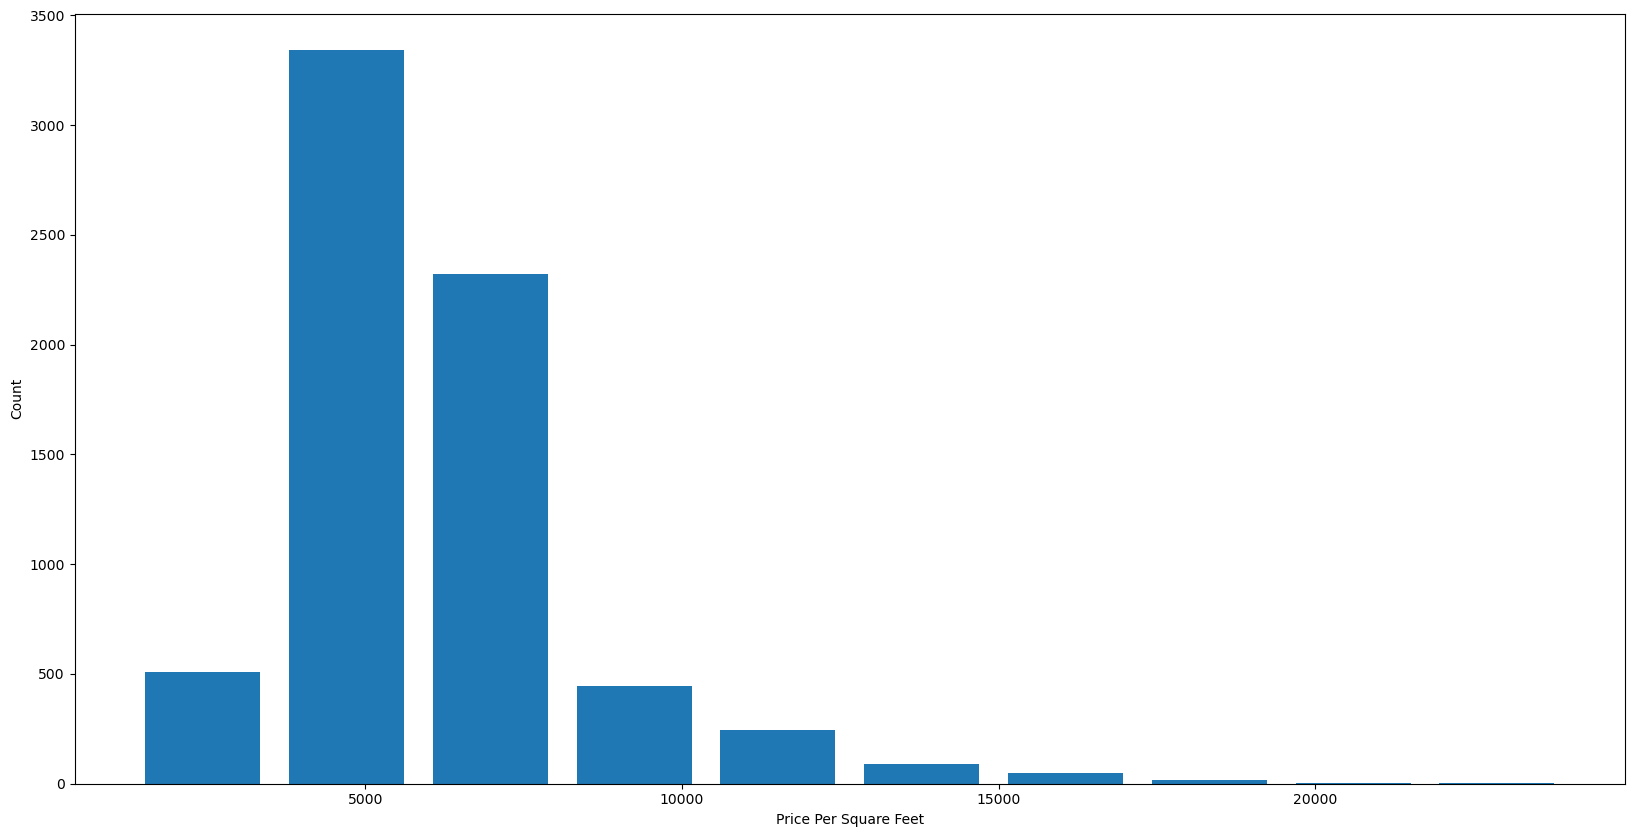

In [23]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df7.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

In [24]:
df7[df7.bath>10]

,location,size,total_sqft,bath,balcony,price,N_bed,price_per_sqft
9267,other,13 BHK,5425.0,13.0,0.0,275.0,13,5069.124424


In [25]:
df8 = df7[df7.bath<df7.N_bed+2]
df8.shape

(6947, 8)

In [26]:
df9 = df8.drop(['size','price_per_sqft'],axis='columns')
df9.head(3)

,location,total_sqft,bath,balcony,price,N_bed
0,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3


## Use One Hot Encoding for categorical variables

In [27]:
df9['location'].nunique()

236

In [28]:
dummies = pd.get_dummies(df9.location)
dummies.head(5)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,AECS Layout,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [29]:
df10 = pd.concat([df9,dummies.drop('other',axis='columns')],axis='columns')
df10.head()

,location,total_sqft,bath,balcony,price,N_bed,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,1.0,428.0,4,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,2.0,194.0,3,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,3.0,235.0,3,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,0.0,130.0,3,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,2.0,148.0,2,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
df11 = df10.drop('location',axis='columns')
df11.shape

(6947, 240)

# Build a regression Model

In [31]:
# # Split data in to training and test sets
X = df11.drop(['price'],axis='columns')
y = df11.price

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [37]:
# Built Linear regression model
R_model = LinearRegression()
R_model.fit(X_train,y_train)
R_model.score(X_test,y_test)

0.8588667416904568

#### Here we I am using K Fold cross-validation to measure accuracy of LinearRegression model

Cross-validation is a technique that involves partitioning the data into multiple subsets (folds) and training/testing the model multiple times, each time using a different subset as the test set and the remaining subsets as the training set.

In [45]:
# Define the K-Fold cross-validation configuration
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Use cross_val_score to evaluate the model using K-Fold cross-validation
scores = cross_val_score(R_model, X, y, cv=kfold, scoring='r2')

In [46]:
# Print the accuracy scores for each fold
print("R^2 scores for each fold:", scores)

# Print the mean accuracy and standard deviation
print("Mean R^2 score:", scores.mean())
print("Standard deviation of R^2 scores:", scores.std())

R^2 scores for each fold: [0.85740457 0.83638605 0.85043773 0.86543178 0.77951665]
Mean R^2 score: 0.8378353548381569
Standard deviation of R^2 scores: 0.03068063790942366


### GridSearchCV

GridSearchCV is a tool provided by the scikit-learn library in Python that is used for hyperparameter tuning of machine learning models. The primary purpose of GridSearchCV is to exhaustively search for the best combination of hyperparameters for a given estimator (model) by evaluating each combination through cross-validation.

In [56]:
# function is designed to identify the best machine learning model and hyperparameters for a given dataset using GridSearchCV.
def best_model_using_gridsearchcv(X, y):
    algorithm = {
        'linear_regression': {
            'model': Pipeline([
                ('scaler', StandardScaler()), 
                ('regressor', LinearRegression())
            ]),
            'params': {
                'regressor__fit_intercept': [True, False],
                'regressor__positive': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1, 2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error', 'friedman_mse'],
                'splitter': ['best', 'random']
            }
        },
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algorithm_name, config in algorithm.items():
        gs = GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'model': algorithm_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    results_df = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
    return results_df

# Example usage
# Assuming X and y are your features and target variable
# X = ...
# y = ...
results = best_model_using_gridsearchcv(X, y)
print(results)

               model  best_score  \
0  linear_regression    0.845123   
1              lasso    0.683869   
2      decision_tree    0.732391   

                                         best_params  
0  {'regressor__fit_intercept': True, 'regressor_...  
1                {'alpha': 1, 'selection': 'random'}  
2  {'criterion': 'squared_error', 'splitter': 'ra...  


### Test the model for few properties

In [60]:
def predict_price(location,sqft,bath,N_bed):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = N_bed
    if loc_index >= 0:
        x[loc_index] = 1

    return R_model.predict([x])[0]

In [61]:
predict_price('1st Phase JP Nagar',1000, 2, 2)

C:\Users\Specter\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


92.71635085336885

In [62]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

C:\Users\Specter\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


92.8056444126378